# Calculate CO2 forcing in each model

In [1]:
import os
import glob
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd

from scipy.stats import linregress
from scipy.optimize import curve_fit

## CO2 ERF as a function of concentration

- We want to determine what the CO2 ERF is for an arbritrary CO2 concentration
- could use the 1pctCO2 run to plot ERF as a function of concentration which opens up to more models
- in fact let's do that, and fit Etminan parameters to each

In [2]:
co2_conc_1pct = 1.01 ** np.arange(181) * 284.316999854786   # Meinshausen uses exactly this def, see supplementary XLS files to Meinshausen et al. 2017

In [3]:
x0=284.316999854786

def myhre(x, d):
    return d * np.log(x/x0)
    

def etminan(x, a, b, d):
    return (a * (x - x0)**2 + b * (x - x0) + d) * np.log(x / x0)


def meinshausen(x, a, b, d):
    c_alpha_max = x0 - b/(2*a)
    alpha_prime = a * (x - x0)**2 + b * (x - x0) + d
    alpha_prime[x>c_alpha_max] = d - b**2/(4*a)
    alpha_prime[x<x0] = d   # should not occur in this calibration
    return alpha_prime * np.log(x / x0)

In [4]:
co2_1pct_erf = {}
regress = {}
myhre_fit = {}
etminan_fit = {}
meinshausen_fit = {}
model_paths = glob.glob('../data/transient_forcing_estimates/*/')
for model_path in model_paths:
    model = model_path.split('/')[-2]
    model_run_paths = glob.glob(model_path + '1pctCO2/*.csv')
    n_runs = len(model_run_paths)
    for i_run, model_run_path in enumerate(model_run_paths):
        this_erf = pd.read_csv(model_run_path)['ERF'].values
        if i_run==0:
            erf = np.zeros_like(this_erf)
        truncate_at = min(len(this_erf), len(erf))
        erf = erf[:truncate_at] + this_erf[:truncate_at]
    co2_1pct_erf[model] = erf / n_runs
    regress[model] = linregress(np.log(co2_conc_1pct[:len(co2_1pct_erf[model])]), co2_1pct_erf[model])
    myhre_fit[model] = curve_fit(
        myhre,
        co2_conc_1pct[:len(co2_1pct_erf[model])], 
        co2_1pct_erf[model],
        p0 = [5.35],
    )
    etminan_fit[model] = curve_fit(
        etminan, 
        co2_conc_1pct[:len(co2_1pct_erf[model])], 
        co2_1pct_erf[model], 
        p0=[-2.4e-7, 7.2e-4, 5.43],
#        bounds=((-np.inf, 0, -np.inf), (0, np.inf, np.inf))
    )
    meinshausen_fit[model] = curve_fit(
        meinshausen, 
        co2_conc_1pct[:len(co2_1pct_erf[model])], 
        co2_1pct_erf[model], 
        p0=[-2.4e-7, 7.2e-4, 5.43],
        bounds = ((-np.inf, 0, 0), (0, np.inf, np.inf)),
        max_nfev=10000
    )
    #print(regress[model].slope*log_conc_co2_1pct[0] + regress[model].intercept)

In [5]:
meinshausen_fit

{}

## Check linearity of 1pctCO2 forcing in each model

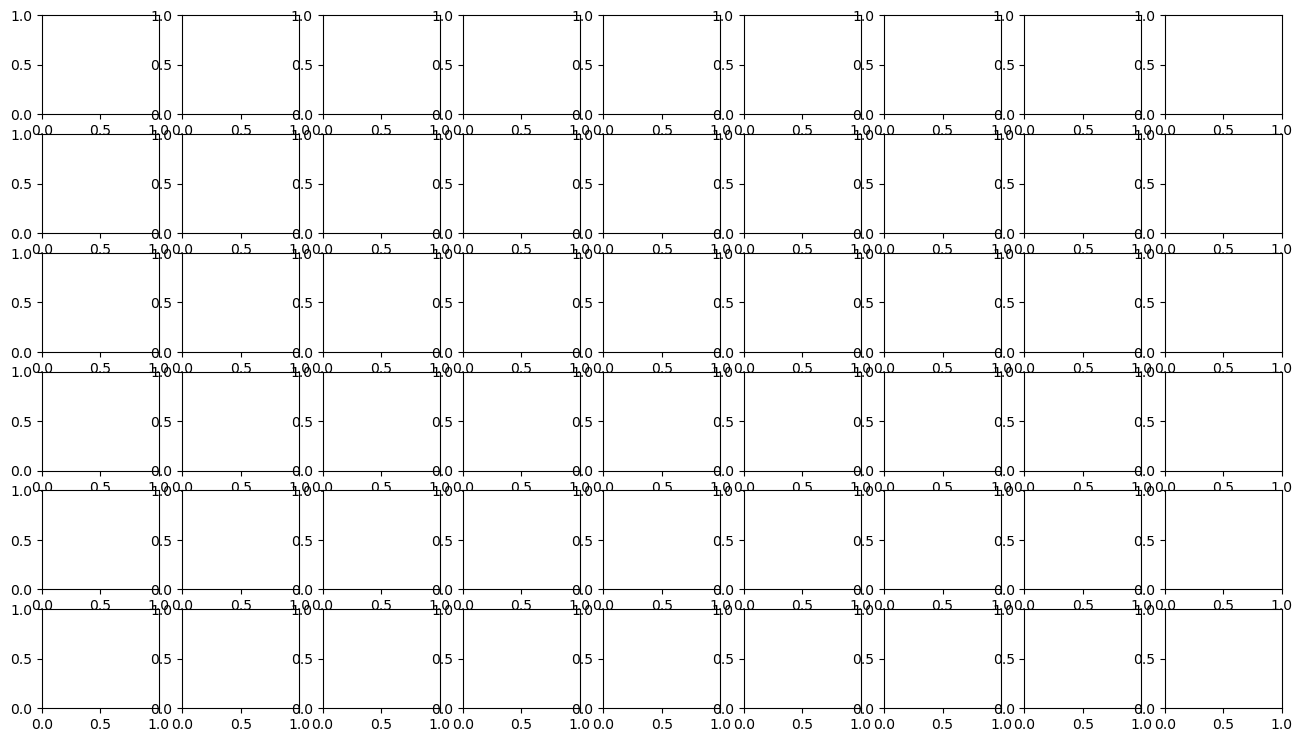

In [7]:
fig, ax = pl.subplots(6, 9, figsize=(16, 9))
for i_model, model in enumerate(co2_1pct_erf):
    ax_i = i_model//9
    ax_j = i_model%9
    ax[ax_i,ax_j].scatter(np.log(co2_conc_1pct[:len(co2_1pct_erf[model])]), co2_1pct_erf[model])
    ax[ax_i,ax_j].plot(
        np.log(co2_conc_1pct[:len(co2_1pct_erf[model])]), 
        np.log(co2_conc_1pct[:len(co2_1pct_erf[model])])*regress[model].slope + regress[model].intercept,
        color='k'
    )

## Myhre relationships in each model

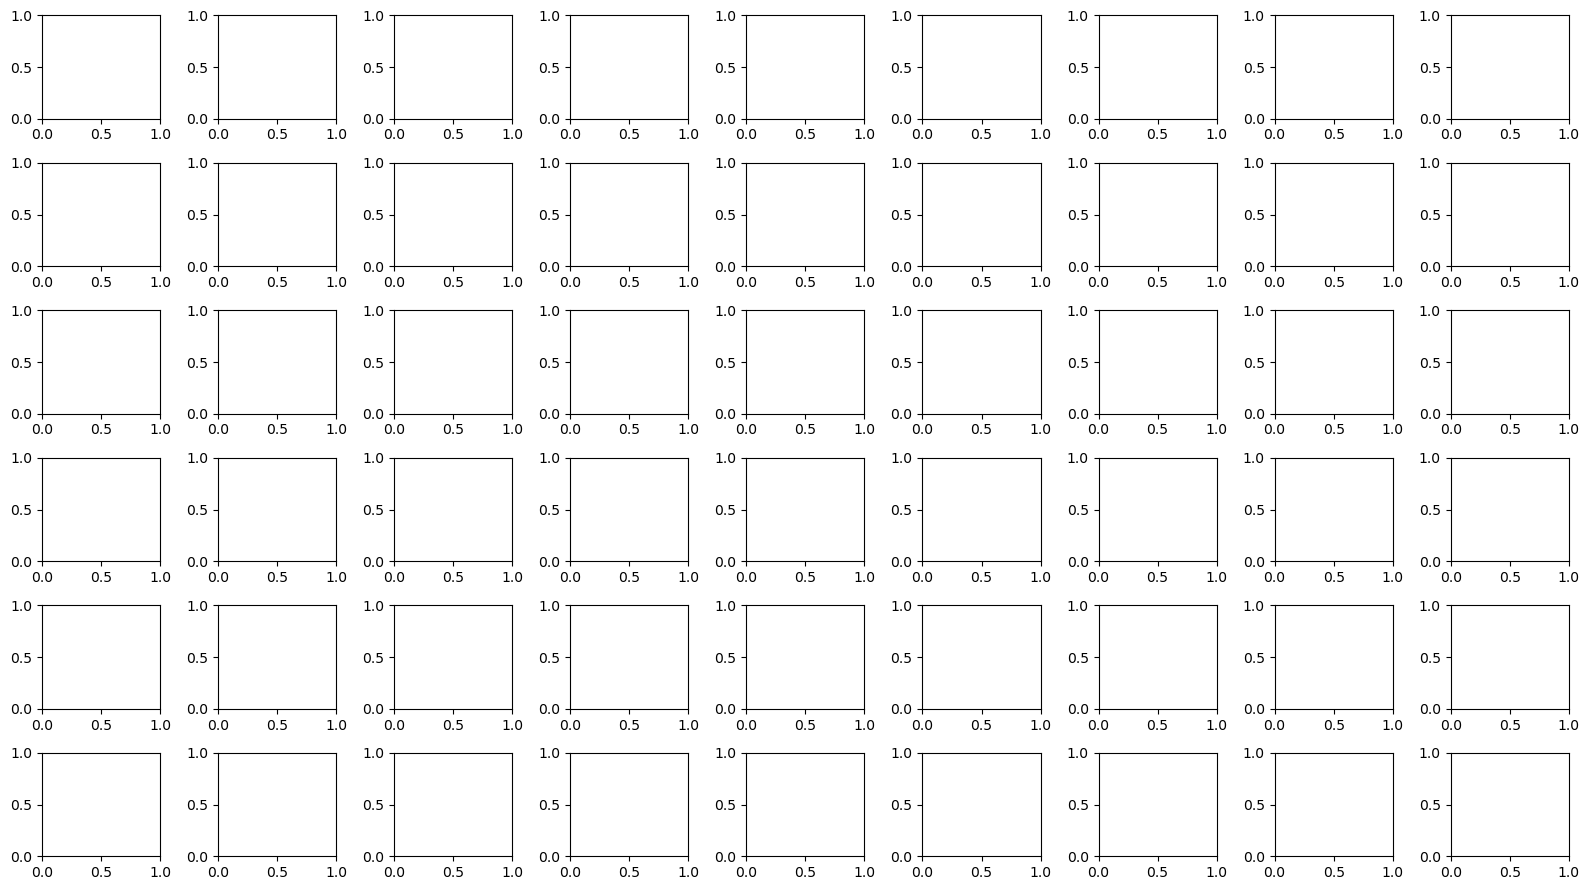

In [8]:
fig, ax = pl.subplots(6, 9, figsize=(16, 9))
for i_model, model in enumerate(co2_1pct_erf):
    ax_i = i_model//9
    ax_j = i_model%9
    ax[ax_i,ax_j].scatter(co2_conc_1pct[:len(co2_1pct_erf[model])], co2_1pct_erf[model])
    ax[ax_i,ax_j].plot(
        co2_conc_1pct[:len(co2_1pct_erf[model])],
        myhre(co2_conc_1pct[:len(co2_1pct_erf[model])], myhre_fit[model][0][0]),
        color='k'
    )
    ax[ax_i,ax_j].set_title(model, fontsize=9)
fig.tight_layout()

## Etminan relationships in each model

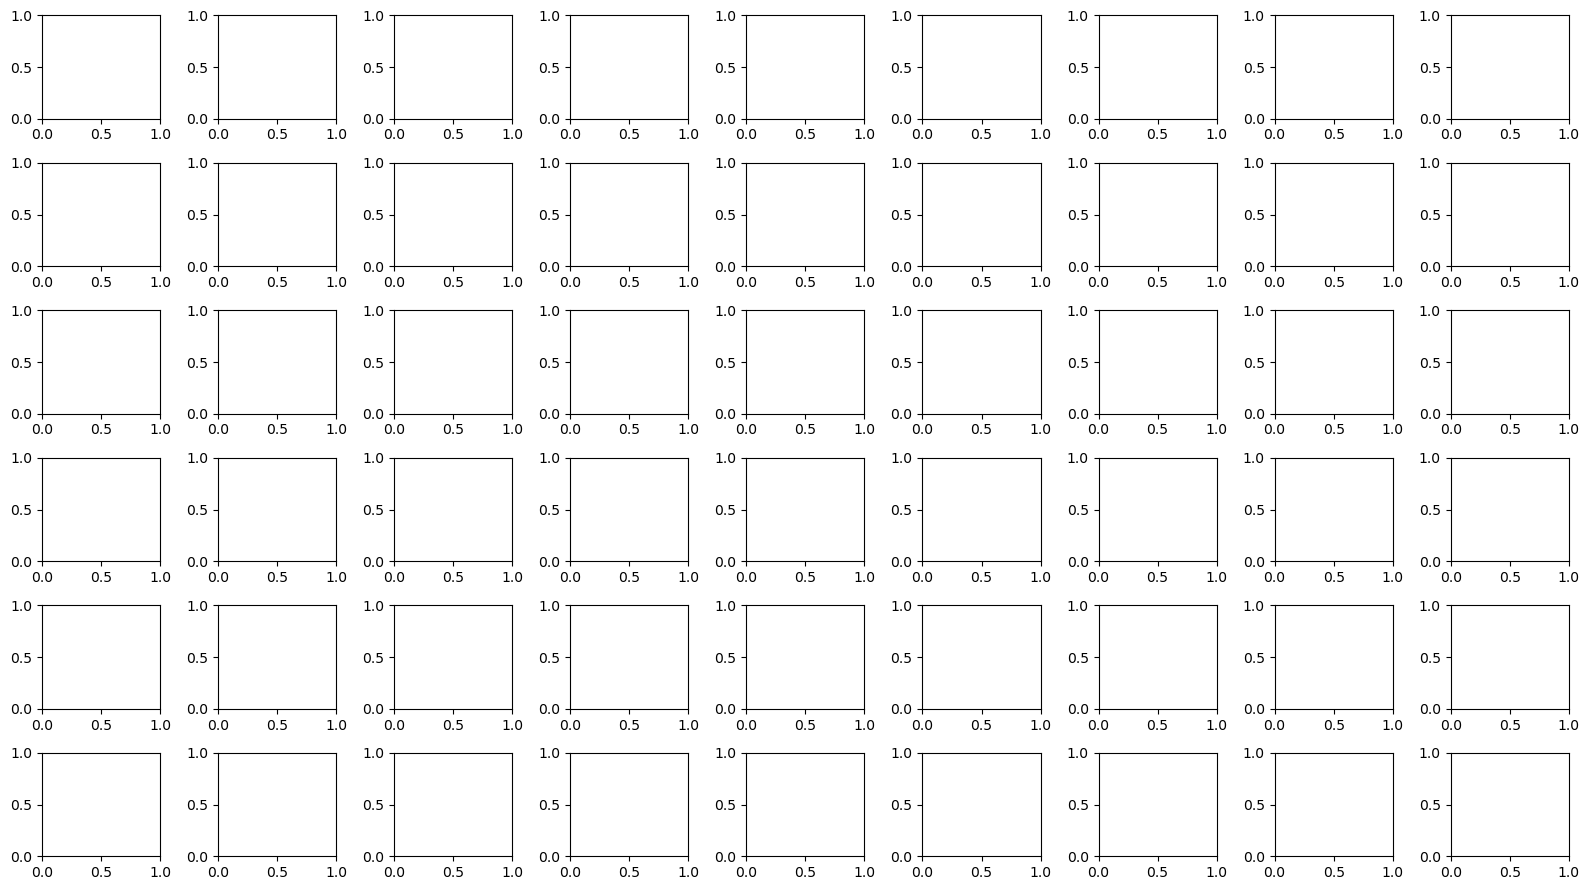

In [9]:
fig, ax = pl.subplots(6, 9, figsize=(16, 9))
for i_model, model in enumerate(co2_1pct_erf):
    ax_i = i_model//9
    ax_j = i_model%9
    ax[ax_i,ax_j].scatter(co2_conc_1pct[:len(co2_1pct_erf[model])], co2_1pct_erf[model])
    ax[ax_i,ax_j].plot(
        co2_conc_1pct[:len(co2_1pct_erf[model])],
        etminan(co2_conc_1pct[:len(co2_1pct_erf[model])], etminan_fit[model][0][0], etminan_fit[model][0][1], etminan_fit[model][0][2]),
        color='k'
    )
    ax[ax_i,ax_j].set_title(model, fontsize=9)
fig.tight_layout()

## Meinshausen relationships

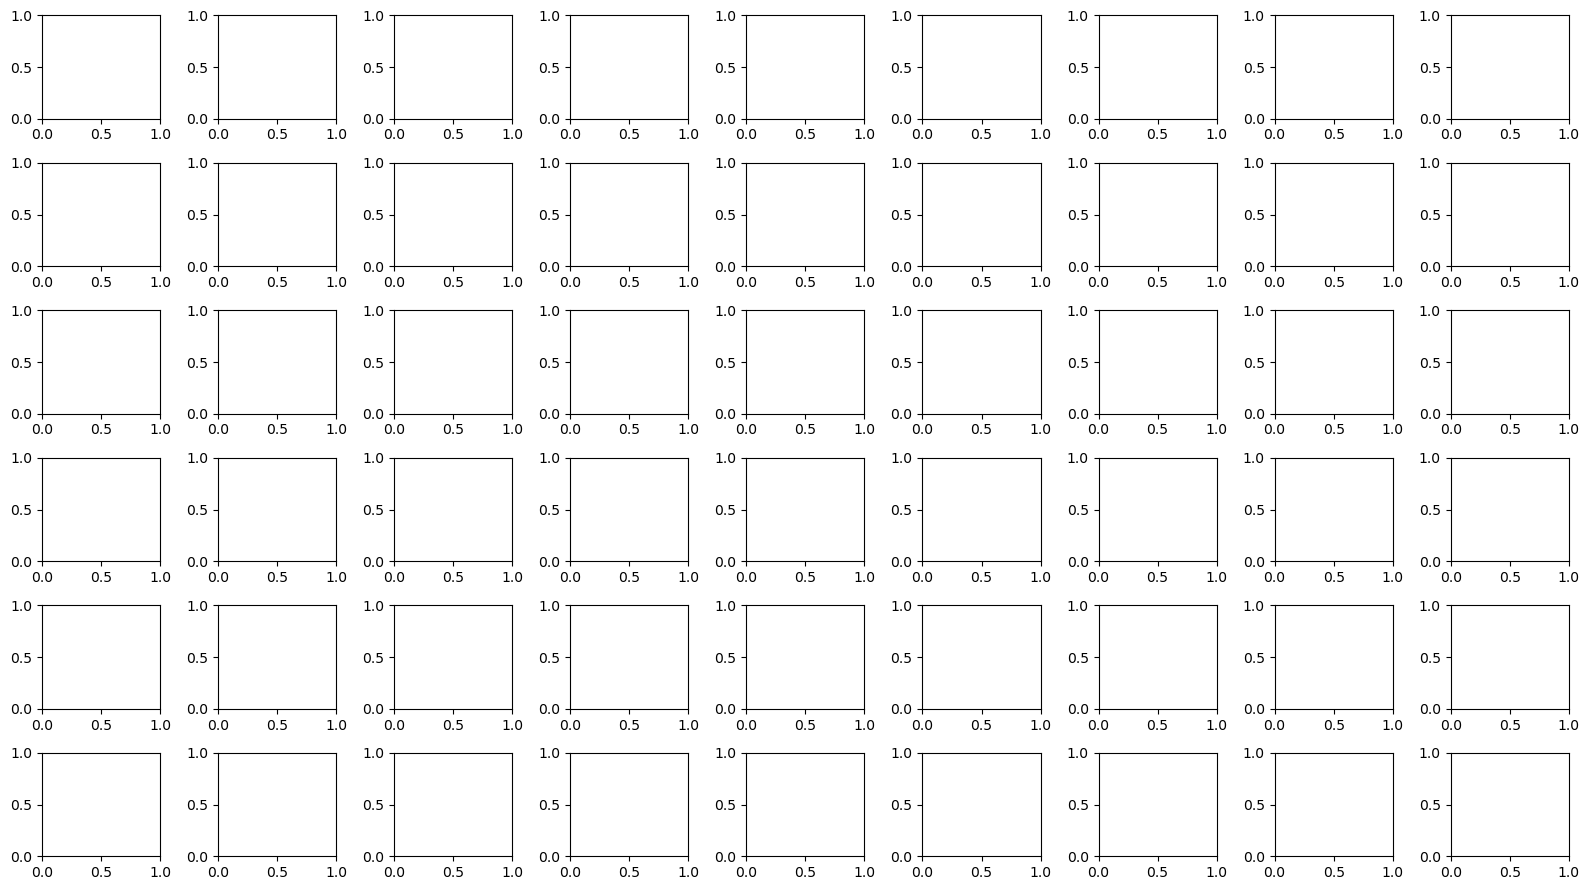

In [10]:
fig, ax = pl.subplots(6, 9, figsize=(16, 9))
for i_model, model in enumerate(co2_1pct_erf):
    ax_i = i_model//9
    ax_j = i_model%9
    ax[ax_i,ax_j].scatter(co2_conc_1pct[:len(co2_1pct_erf[model])], co2_1pct_erf[model])
    ax[ax_i,ax_j].plot(
        co2_conc_1pct[:len(co2_1pct_erf[model])],
        meinshausen(co2_conc_1pct[:len(co2_1pct_erf[model])], meinshausen_fit[model][0][0], meinshausen_fit[model][0][1], meinshausen_fit[model][0][2]),
        color='k'
    )
    ax[ax_i,ax_j].set_title(model, fontsize=9)
fig.tight_layout()

In [11]:
myhre_fit

{}

In [12]:
rows = []
for model in co2_1pct_erf:
    rows.append([model, myhre_fit[model][0][0]])
df_out = pd.DataFrame(rows, columns=['model', 'd1'])
df_out.set_index('model')

os.makedirs('../output', exist_ok=True)
df_out.to_csv('../output/myhre_forcing_params.csv', index=False)

PermissionError: [Errno 13] Permission denied: '../output'

In [ ]:
rows = []
for model in co2_1pct_erf:
    rows.append([model, etminan_fit[model][0][0], etminan_fit[model][0][1], etminan_fit[model][0][2]])
df_out = pd.DataFrame(rows, columns=['model', 'a1', 'b1', 'd1'])
df_out.set_index('model')

os.makedirs('../output', exist_ok=True)
df_out.to_csv('../output/etminan_forcing_params.csv', index=False)

In [ ]:
rows = []
for model in co2_1pct_erf:
    rows.append([model, meinshausen_fit[model][0][0], meinshausen_fit[model][0][1], meinshausen_fit[model][0][2]])
df_out = pd.DataFrame(rows, columns=['model', 'a1', 'b1', 'd1'])
df_out.set_index('model')

os.makedirs('../output', exist_ok=True)
df_out.to_csv('../output/meinshausen_forcing_params.csv', index=False)

In [ ]:
c0 = 284.316999854786

In [ ]:
for model in co2_1pct_erf:
    print(model, c0 - meinshausen_fit[model][0][1] / (2*meinshausen_fit[model][0][0]))